<a href="https://colab.research.google.com/github/arifpras/ExpectedDemand/blob/main/20240528_podem02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="markdown-google-sans">

  <h1> Predicting Demand in the Primary Market: Pycaret</h1>
</div>

<div class="markdown-google-sans">

## <strong> Data Preparation </strong>
</div>

## Libraries

In [ ]:
%%capture

# !pip install -U scikit-learn==0.24.2
# !pip install -U imbalanced-learn

# %pip install openpyxl
# %pip install shap
# %pip install pycaret

!pip show pycaret || pip install pycaret

In [ ]:
# Subsequent cells can use the installed library
import pycaret
pycaret.__version__

'3.3.2'

In [ ]:
from pycaret.regression import *

import numpy as np
import pandas as pd
import openpyxl as xl
import matplotlib.pyplot as plt
import seaborn as sns

## Database

### Load

In [ ]:
df_train00 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='database')
df_train00['incoming_bid'] = df_train00['incoming_bid'].astype(float)
df_train00['issuance_date'] = pd.to_datetime(df_train00['issuance_date'], format='%Y-%m-%d')

df_train00.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     1952 non-null   object        
 1   issuance_date     1952 non-null   datetime64[ns]
 2   issuance_year     1952 non-null   int64         
 3   issuance_week     1952 non-null   int64         
 4   monthfrac         1952 non-null   int64         
 5   eid_weeks         1952 non-null   int64         
 6   srbi_issuance     1952 non-null   int64         
 7   vix_indicator     1952 non-null   int64         
 8   bi_covid          1952 non-null   int64         
 9   gso_issuance      1952 non-null   int64         
 10  investment_grade  1952 non-null   int64         
 11  incoming_bid      1952 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(1)
memory usage: 183.1+ KB


In [ ]:
df_train00['issued_series'].value_counts()

issued_series
sun10    300
sun20    295
spn12    280
sun15    280
sun05    274
spn03    246
sun30    178
spn09     76
sun07     11
sun08      9
sun04      1
vr04       1
sun02      1
Name: count, dtype: int64

In [ ]:
df_train00.describe()

,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,incoming_bid
count,1952,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1.952000e+03
mean,2017-10-13 14:08:21.639344128,2017.339139,24.256660,124.544570,0.081455,0.054816,0.079918,0.241803,0.022029,0.864242,6.297643e+06
min,2009-01-13 00:00:00,2009.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2014-02-18 00:00:00,2014.000000,12.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.403300e+06
50%,2018-07-24 00:00:00,2018.000000,24.000000,119.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.452200e+06
75%,2021-06-22 00:00:00,2021.000000,36.000000,189.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.009500e+06
max,2024-05-14 00:00:00,2024.000000,51.000000,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.516780e+07
std,NaN,4.366329,14.070308,108.654428,0.273603,0.227678,0.271236,0.428285,0.146814,0.342619,5.917738e+06


<Axes: xlabel='incoming_bid', ylabel='issuance_week'>

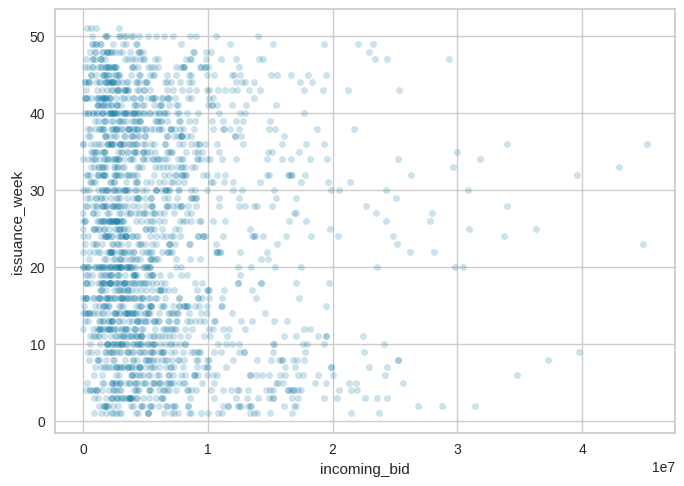

In [ ]:
df_train00.plot(kind = 'scatter', x = 'incoming_bid', y = 'issuance_week', alpha = 0.2)

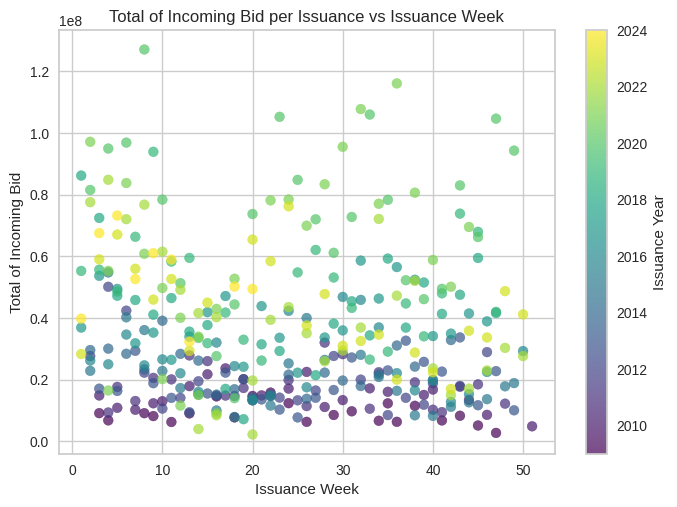

In [ ]:
# import matplotlib.pyplot as plt

grouped_series01 = df_train00.groupby(['issuance_date']).agg({
    'incoming_bid': 'sum',
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series01['issuance_year'] = grouped_series01['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series01['issuance_week'], grouped_series01['incoming_bid'], s=50, c=grouped_series01['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Total of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Total of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

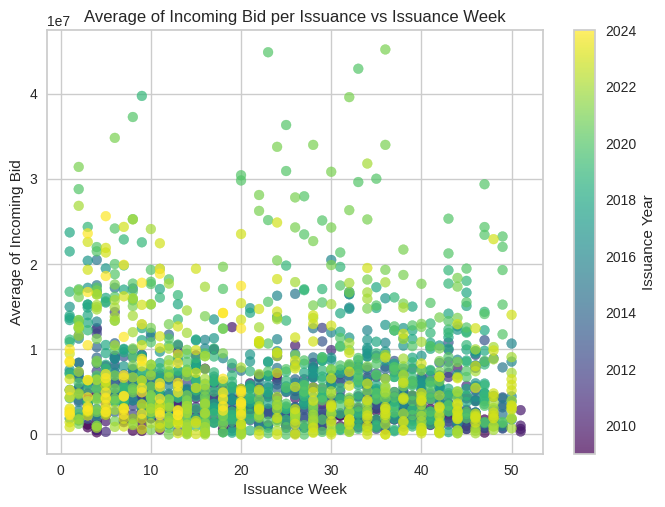

In [ ]:
# import matplotlib.pyplot as plt

grouped_series02 = df_train00.groupby(['issuance_date', 'issued_series']).agg({
    'incoming_bid': 'mean', #average
    'issuance_week': 'mean',
    'issuance_year': 'mean'
}).reset_index()

# Convert 'issuance_year' to integer
grouped_series02['issuance_year'] = grouped_series02['issuance_year'].astype(int)


# Scatter plot
# plt.figure(figsize=(10, 6))
plt.scatter(grouped_series02['issuance_week'], grouped_series02['incoming_bid'], s=50, c=grouped_series02['issuance_year'], alpha=0.7, cmap='viridis')
plt.title('Average of Incoming Bid per Issuance vs Issuance Week')
plt.xlabel('Issuance Week')
plt.ylabel('Average of Incoming Bid')
plt.colorbar(label='Issuance Year')
plt.grid(True)
plt.show()

In [ ]:
# sns.catplot(x='issued_series', y='incoming_bid', data=grouped_series02,
#                 kind='boxen', col='issuance_year', col_wrap=2)

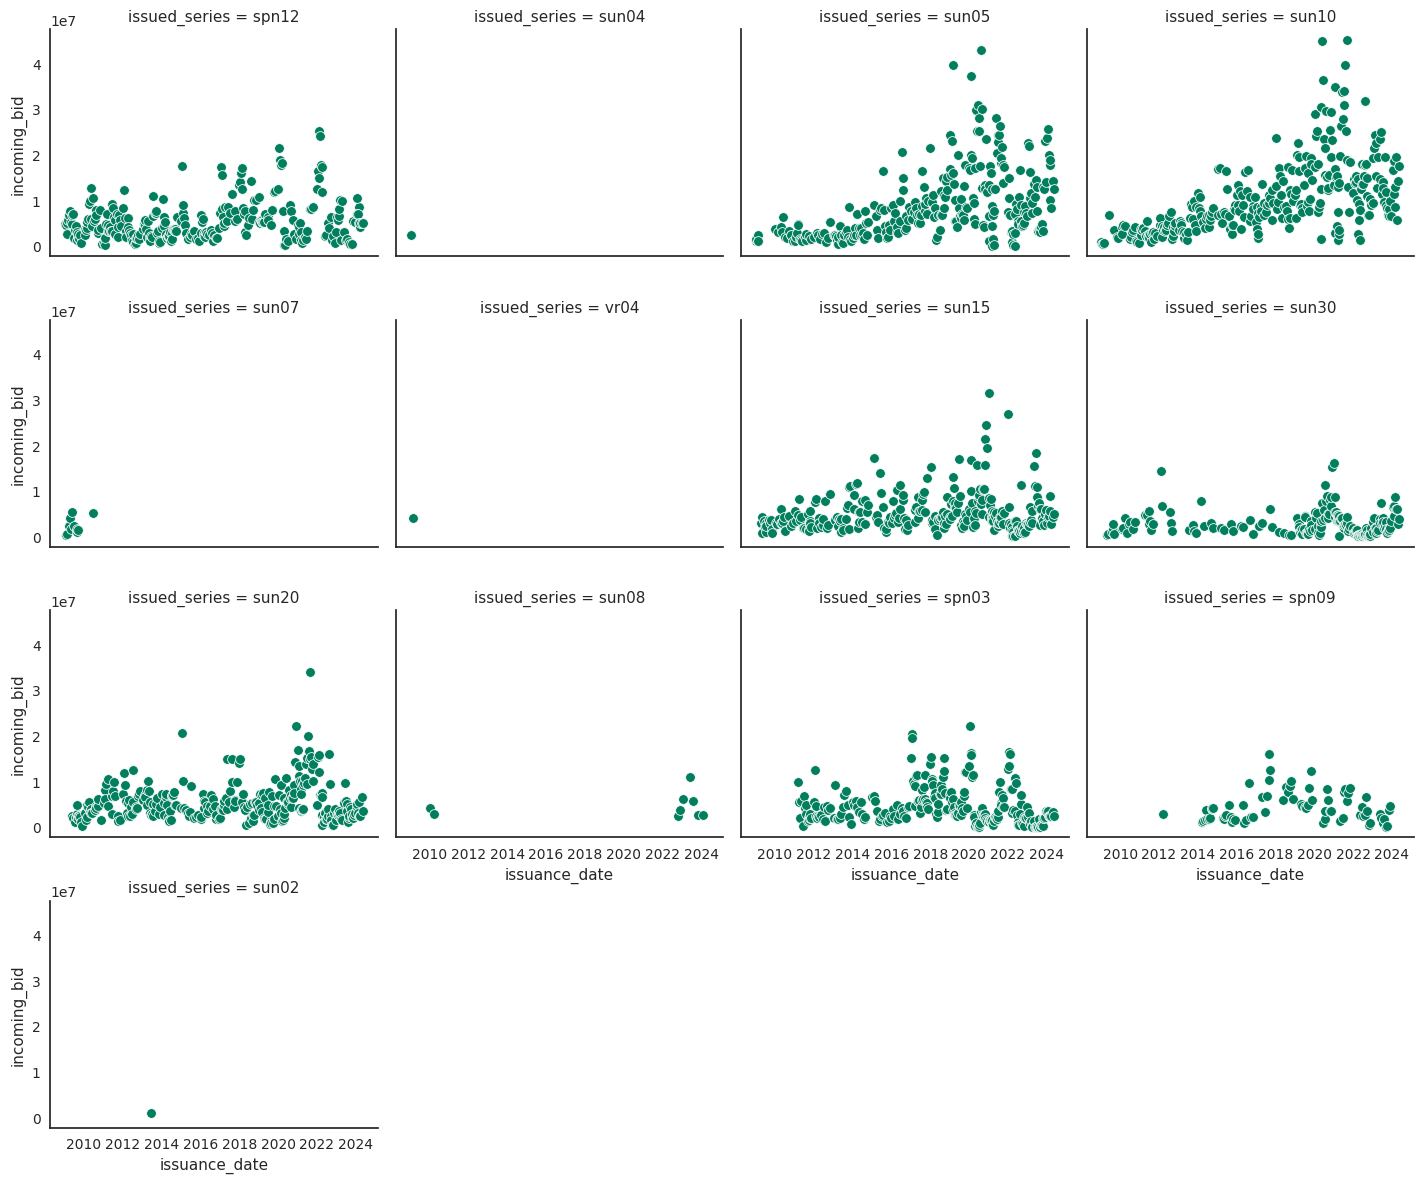

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch01 = sns.FacetGrid(df_train00, col='issued_series', col_wrap=4, height=3, aspect=1.2)
ch01.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
# corr_matrix = df_train00.corr()
# corr_matrix['incoming_bid'].sort_values(ascending=False)

In [ ]:
df_train01 = df_train00[~df_train00['issued_series'].isin(['sun04', 'sun02', 'vr04', 'spn09', 'sun07'])]

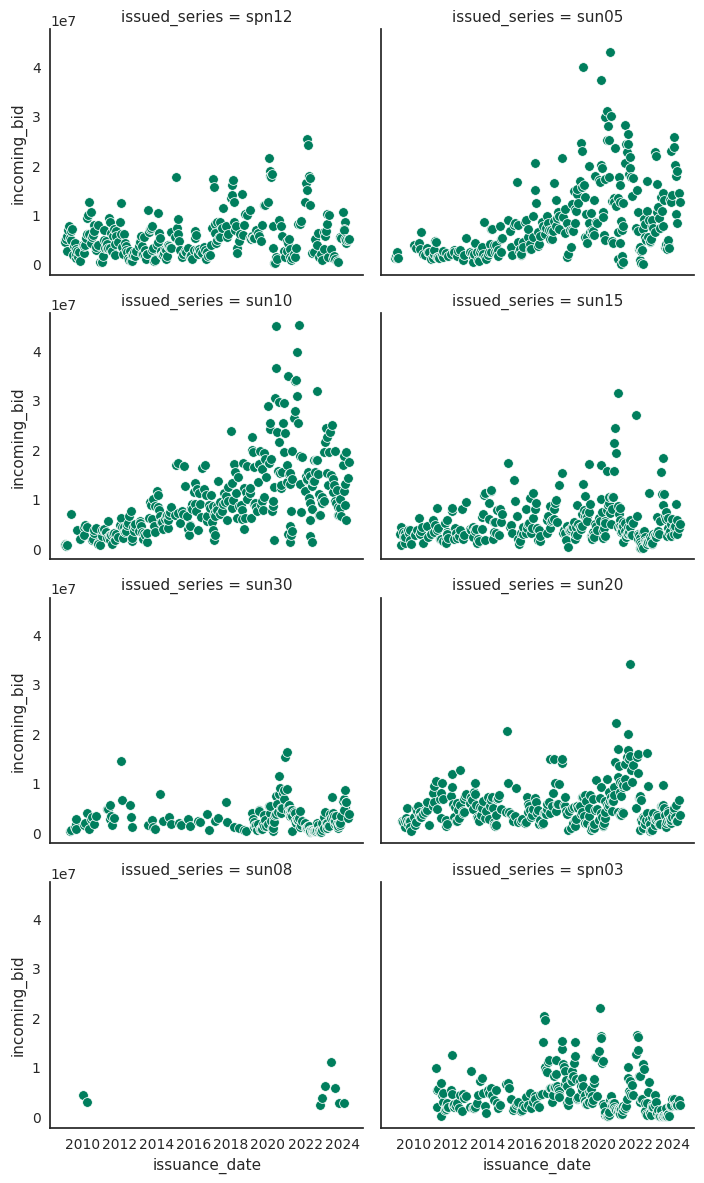

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

sns.set_style("white")

# Create a FacetGrid and use map to create subplots based on 'FacetVar'
ch02 = sns.FacetGrid(df_train01, col='issued_series', col_wrap=2, height=3, aspect=1.2)
ch02.map(sns.scatterplot, 'issuance_date', 'incoming_bid', color='#007e5d')

# Show the plot
# plt.show()


In [ ]:
# Get the order of categories
issd_series = df_train01['issued_series'].unique()

# Sort the order
issd_series.sort()

# Create a boxplot with sorted order
# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series, hue='issuance_year')

# sns.boxplot(x='issued_series', y='incoming_bid', data=df_train01,
#             order=issd_series)
# plt.show()

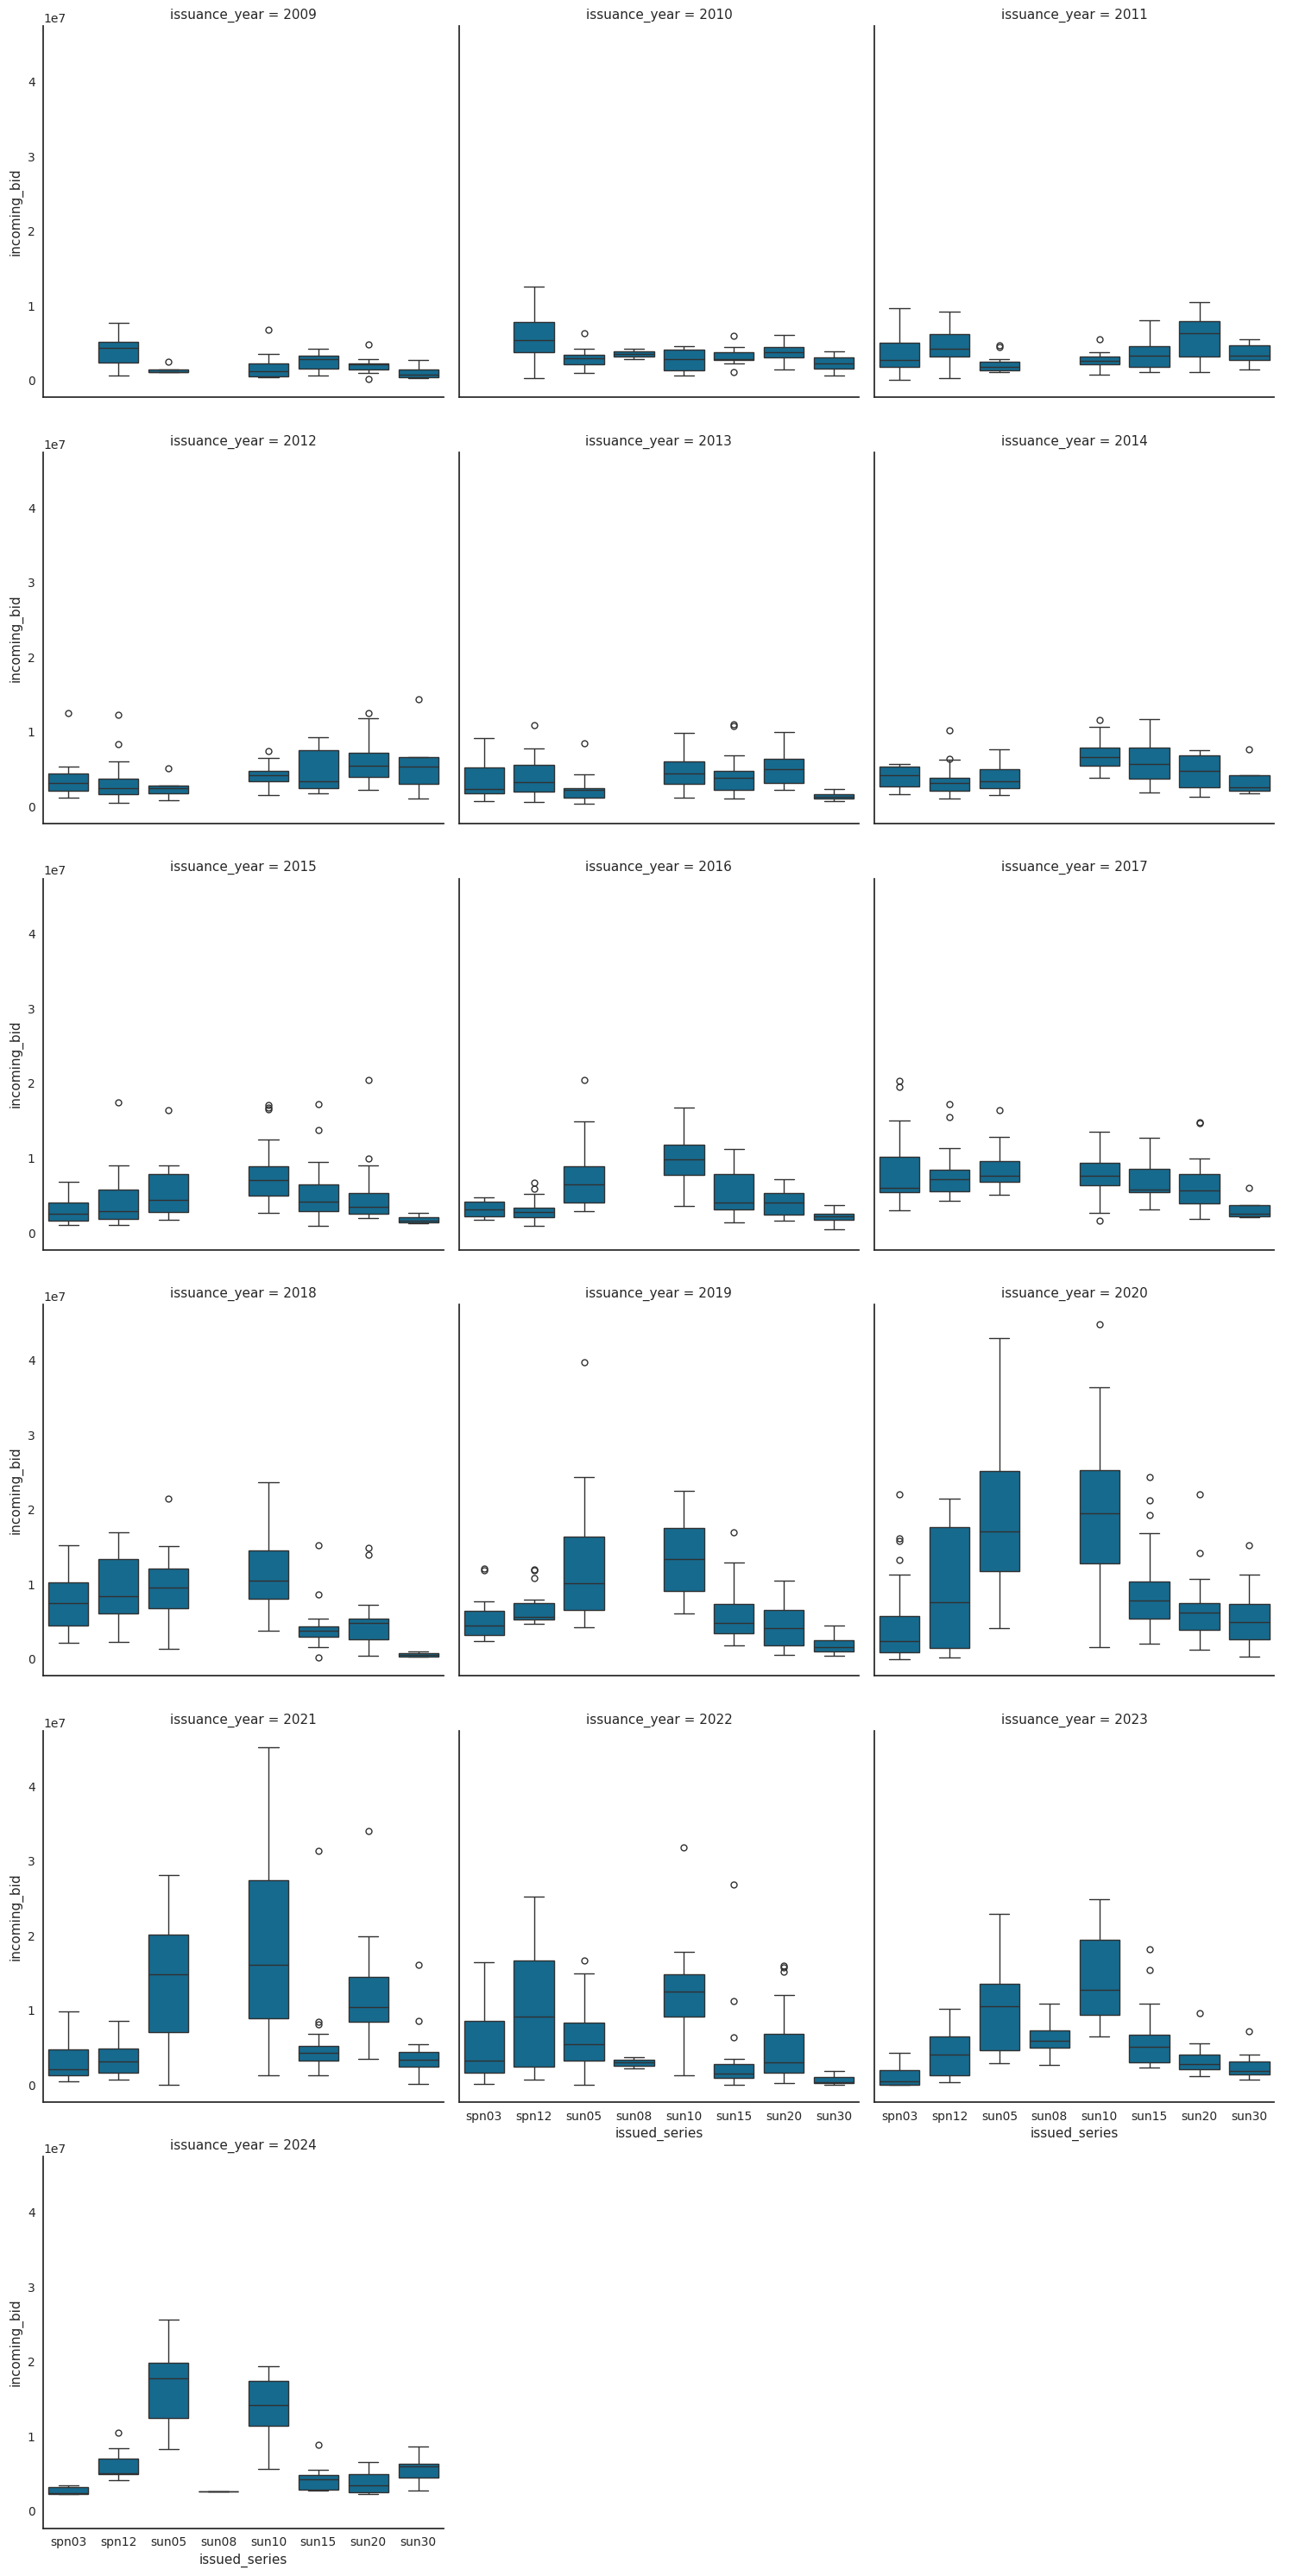

In [ ]:
sns.catplot(x='issued_series', y='incoming_bid', data=df_train01,
                order=issd_series, kind='box', col='issuance_year', col_wrap=3)

### Split: Biased

In [ ]:
# df_train02 = df_train01.sample(frac=0.9, random_state=786)
# df_unseen01 = df_train01.drop(df_train02.index)

# df_train02.reset_index(drop=True, inplace=True)
# df_unseen01.reset_index(drop=True, inplace=True)

# print('Data for Modeling: ' + str(df_train02.shape))
# print('Unseen Data For Predictions: ' + str(df_unseen01.shape))

In [ ]:
# print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

### Split: Stratified

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming df is your DataFrame and 'target_column' is the target variable
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_index in split.split(df_train01, df_train01['issued_series']):
    # Explicitly reset the index
    df_train02 = df_train01.iloc[train_index]
    df_unseen01 = df_train01.iloc[test_index]

# Explicitly reset the index for df_train02 and df_test01
# df_train02 = df_train02.reset_index(drop=True)
# df_unseen01 = df_unseen01.reset_index(drop=True)

# Display the shapes of the resulting sets (optional)
print("Train set shape:", df_train02.shape)
print("Test set shape:", df_unseen01.shape)

Train set shape: (1675, 12)
Test set shape: (187, 12)


In [ ]:
print("Train: \n{} \n\nTest: \n{}".format(df_train02['issued_series'].value_counts(), df_unseen01['issued_series'].value_counts()))

Train: 
issued_series
sun10    270
sun20    265
sun15    252
spn12    252
sun05    247
spn03    221
sun30    160
sun08      8
Name: count, dtype: int64 

Test: 
issued_series
sun10    30
sun20    30
sun15    28
spn12    28
sun05    27
spn03    25
sun30    18
sun08     1
Name: count, dtype: int64


In [ ]:
# Identifying duplicates
duplicates = df_train02[df_train02.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)


Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


In [ ]:
# Identifying duplicates
duplicates = df_unseen01[df_unseen01.index.duplicated()]
print("Rows with duplicate indices:")
print(duplicates)

Rows with duplicate indices:
Empty DataFrame
Columns: [issued_series, issuance_date, issuance_year, issuance_week, monthfrac, eid_weeks, srbi_issuance, vix_indicator, bi_covid, gso_issuance, investment_grade, incoming_bid]
Index: []


# Methods

## Setup

In [ ]:
session01 = setup(data=df_train02, target='incoming_bid', session_id=123,
                  test_data=df_unseen01,
                  categorical_features=['issued_series'],
                  ignore_features = ['issuance_date'])

,Description,Value
0,Session id,123
1,Target,incoming_bid
2,Target type,Regression
3,Original data shape,"(1862, 12)"
4,Transformed data shape,"(1862, 18)"
5,Transformed train set shape,"(1675, 18)"
6,Transformed test set shape,"(187, 18)"
7,Ignore features,1
8,Numeric features,9
9,Categorical features,1


## Compare Models

In [ ]:
best01 = compare_models(sort = 'rmse')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,2335142.8875,12229528780800.0000,3466746.8500,0.6680,1.1579,0.8174,0.2140
et,Extra Trees Regressor,2360474.3771,12450895135770.2559,3506546.5045,0.6580,1.0499,0.8148,0.4230
rf,Random Forest Regressor,2377945.2115,12667688098293.4043,3530049.9965,0.6546,1.1535,0.8820,0.8390
lightgbm,Light Gradient Boosting Machine,2423691.0966,12855651770563.5801,3545196.0713,0.6527,1.1762,0.9650,0.8730
gbr,Gradient Boosting Regressor,2891112.4912,17529265766534.0664,4154416.7025,0.5228,1.2666,1.2210,0.1880
knn,K Neighbors Regressor,3106516.0000,19849159481753.6016,4429204.4750,0.4534,1.3234,1.8770,0.0680
dt,Decision Tree Regressor,2934067.9505,19867314252010.3359,4435072.5106,0.4433,1.1289,0.7882,0.0690
lasso,Lasso Regression,3677813.6093,26472424595423.5273,5124338.1358,0.2735,1.4766,2.3739,0.1440
llar,Lasso Least Angle Regression,3676296.5942,26473977287979.4375,5124491.7088,0.2734,1.4680,2.3731,0.0700
lr,Linear Regression,3678312.2792,26474207566697.9648,5124514.1633,0.2734,1.4654,2.3740,0.9570


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

## Features

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2613224.8258,15133188700842.8926,3890139.9333,0.6306,2.1150,1.1036
1,2564367.0120,12430539310989.1777,3525696.9965,0.6473,1.2818,0.5978
2,2434162.1103,10446705428947.1602,3232136.3568,0.6753,0.6616,0.8337
3,2205368.0945,10810785710539.2344,3287975.9291,0.6169,1.2932,0.8812
4,2531319.8175,15679190175687.3145,3959695.7176,0.6321,1.2692,0.6506
5,2466202.4041,15293230135433.2637,3910655.9725,0.6273,0.7318,1.0072
6,2372785.9597,10987594065450.0098,3314753.9977,0.6711,0.6483,0.9226
7,2023191.2365,6908406214510.4854,2628384.7158,0.7301,1.3525,0.9235
8,2968167.1512,21405904411107.8242,4626651.5334,0.5397,1.6724,0.7726


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

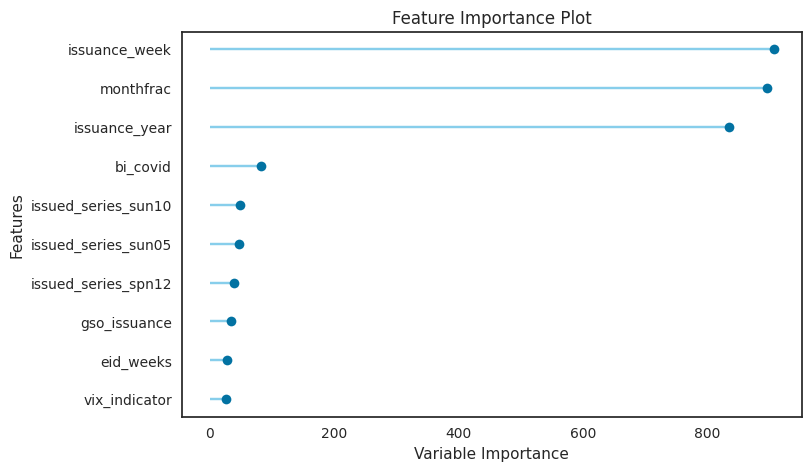

In [ ]:
plot_model(create_model('lightgbm'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2410078.5000,12306465423360.0000,3508057.2500,0.6996,2.1156,0.5399
1,2559629.7500,11981547372544.0000,3461437.2500,0.6600,1.1907,0.5695
2,2196387.2500,9206573826048.0000,3034233.7500,0.7138,0.6287,0.7317
3,2112546.2500,10435543695360.0000,3230409.2500,0.6302,1.3593,1.2733
4,2511479.5000,15944657141760.0000,3993076.2500,0.6259,1.1711,0.6637
5,2441292.0000,15285783363584.0000,3909703.7500,0.6275,0.7191,0.9662
6,2221233.5000,9555182354432.0000,3091145.7500,0.7140,0.6661,0.7781
7,1935431.6250,7752419115008.0000,2784316.7500,0.6971,1.2924,0.6866
8,2900460.0000,18842812153856.0000,4340831.0000,0.5948,1.7263,0.7675


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

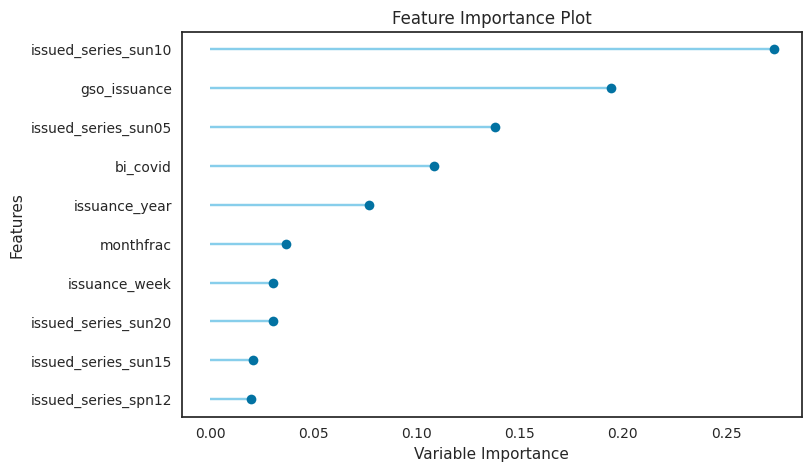

In [ ]:
plot_model(create_model('xgboost'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2448865.3690,12067590213900.4883,3473843.7233,0.7054,1.8563,0.5821
1,2627708.3363,14414666981403.6191,3796665.2448,0.5910,1.2117,0.5441
2,2379983.5238,11848464026728.6074,3442159.7910,0.6317,0.6098,0.6781
3,2126584.5655,11236970771724.9590,3352159.1209,0.6018,1.0455,1.1630
4,2511380.9494,13307493075483.0977,3647943.6777,0.6878,0.9234,0.5972
5,2455619.3653,16116917632879.9863,4014588.1025,0.6072,0.7518,0.9176
6,2150492.7515,9178317494182.0137,3029573.8140,0.7253,0.5451,0.5905
7,1984060.6108,8182407571526.8867,2860490.7921,0.6803,1.2792,0.6617
8,2742279.9581,17489019996295.0586,4181987.5653,0.6239,1.5711,0.6371


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

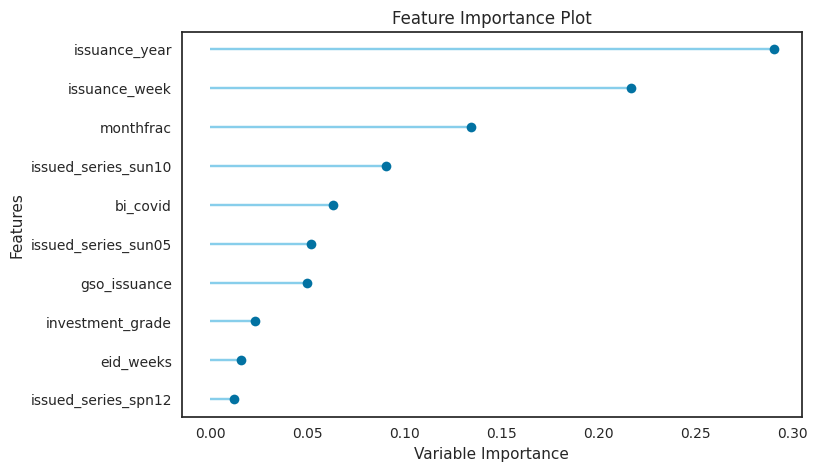

In [ ]:
plot_model(create_model('et'), plot='feature')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2508046.9091,12513584747695.7324,3537454.5577,0.6945,2.2204,0.6930
1,2679400.0829,13392004148135.2383,3659508.7304,0.6200,1.2083,0.5747
2,2388393.8652,10717792684639.9082,3273804.0083,0.6669,0.6378,0.7803
3,2234322.2883,11264582803252.4727,3356275.1382,0.6008,1.3735,1.4847
4,2467753.2986,14836738459056.2012,3851848.7067,0.6519,1.1416,0.6526
5,2472669.4079,15998060291095.1016,3999757.5290,0.6101,0.7230,1.0262
6,2184031.2534,10517583576898.9258,3243082.4191,0.6852,0.5682,0.6346
7,2040079.2750,7722294214287.2578,2778901.6201,0.6983,1.3321,0.8296
8,2915950.2849,19768448344432.4805,4446172.3251,0.5749,1.6397,0.7540


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

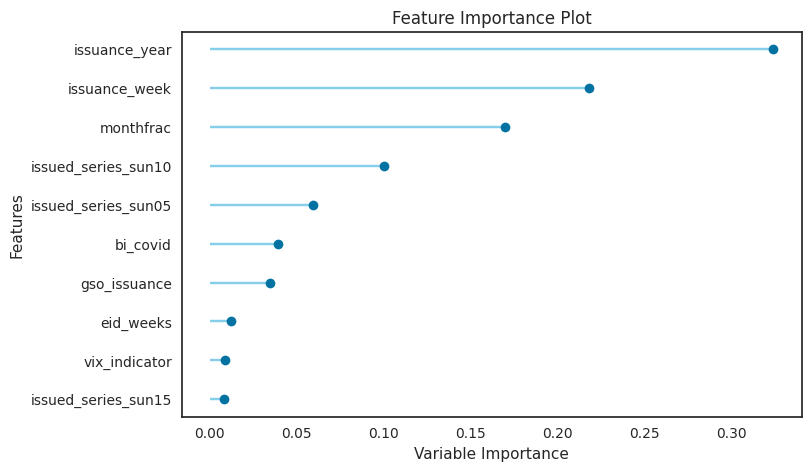

In [ ]:
plot_model(create_model('rf'), plot='feature')

# Algorithms

## Light Gradient Boosting Machine

### Raw -- 65.27%

In [ ]:
# train a xgb model with default params
lightgbm_raw = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2613224.8258,15133188700842.8926,3890139.9333,0.6306,2.1150,1.1036
1,2564367.0120,12430539310989.1777,3525696.9965,0.6473,1.2818,0.5978
2,2434162.1103,10446705428947.1602,3232136.3568,0.6753,0.6616,0.8337
3,2205368.0945,10810785710539.2344,3287975.9291,0.6169,1.2932,0.8812
4,2531319.8175,15679190175687.3145,3959695.7176,0.6321,1.2692,0.6506
5,2466202.4041,15293230135433.2637,3910655.9725,0.6273,0.7318,1.0072
6,2372785.9597,10987594065450.0098,3314753.9977,0.6711,0.6483,0.9226
7,2023191.2365,6908406214510.4854,2628384.7158,0.7301,1.3525,0.9235
8,2968167.1512,21405904411107.8242,4626651.5334,0.5397,1.6724,0.7726


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 62.77%

In [ ]:
# tune hyperparameters of lightgbm
lightgbm_tuned = tune_model(lightgbm_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2811134.1634,16001454323096.6719,4000181.7863,0.6094,2.2751,0.8824
1,2698962.8384,13286328373699.4961,3645041.6148,0.6230,1.1871,0.6020
2,2476755.2712,10952071232949.3750,3309391.3690,0.6596,0.7485,0.8164
3,2207821.1745,10574466167180.7129,3251840.4277,0.6253,1.3337,1.0949
4,2738161.9294,17876039495080.9375,4228006.5628,0.5806,1.2528,0.8126
5,2709536.1529,15960831056450.2070,3995100.8819,0.6110,0.8016,1.1162
6,2514921.9978,12282376105002.2480,3504622.1059,0.6324,0.7855,0.9087
7,2281451.7250,8527607075543.9053,2920206.6837,0.6669,1.3714,0.9982
8,3066216.0962,20598002535065.5898,4538502.2348,0.5570,1.6190,0.7514


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 67.74%

In [ ]:

# Define a more comprehensive tuning grid for LightGBM
lightgbm_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4],
    'num_leaves': [15, 31, 63, 127],
    'min_split_gain': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample_freq': [0, 1, 2],
}

# Tune LightGBM model with custom grid and optimize for R2
lightgbm_modified = tune_model(lightgbm_raw, custom_grid=lightgbm_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2452549.7326,13442029300367.4277,3666337.3140,0.6718,2.1648,0.9059
1,2480490.7026,11682419944842.4785,3417955.5212,0.6685,1.2576,0.5232
2,2355310.7163,10039287289995.2227,3168483.4369,0.6879,0.6658,0.8564
3,2111354.6646,9524603197843.8086,3086195.5865,0.6625,1.3267,0.6927
4,2402320.0922,13905270463473.9414,3728977.1337,0.6738,1.2739,0.6811
5,2372939.4971,13693508367960.9160,3700474.0734,0.6663,0.7194,0.9843
6,2458437.4349,10972380359261.7969,3312458.3559,0.6716,0.7663,0.9765
7,2056547.0704,7154448532898.4131,2674780.0906,0.7205,1.4529,0.8295
8,2991445.3510,19039069993837.7461,4363378.2776,0.5906,1.7650,0.7668


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


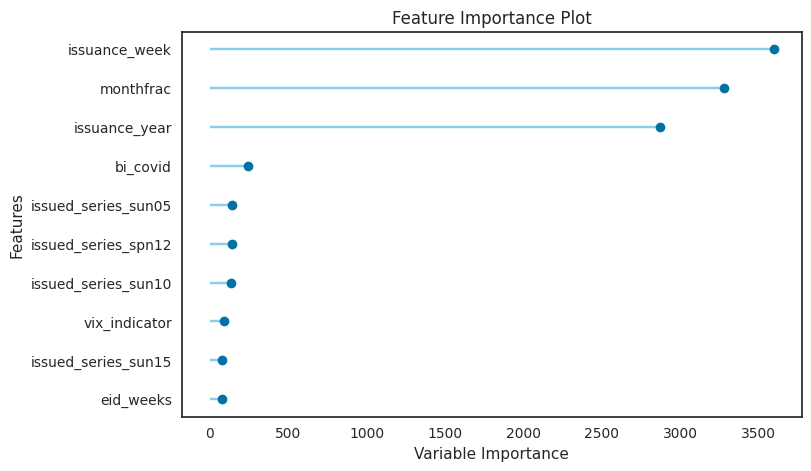

In [ ]:
plot_model(lightgbm_modified, plot = 'feature')

### Bagging -- 64.80%

In [ ]:
# ensemble with bagging
lightgbm_bagged = ensemble_model(lightgbm_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2639902.2315,15454098139077.7441,3931170.0725,0.6227,2.1700,0.8341
1,2558622.9239,12140284040791.1211,3484291.0385,0.6555,1.1533,0.5769
2,2407460.2913,10685745674212.0195,3268905.8834,0.6679,0.6395,0.7903
3,2221141.0384,10543439967964.6367,3247066.3633,0.6264,1.3357,1.2057
4,2463399.5432,15394537116473.0332,3923587.2765,0.6388,1.1655,0.6721
5,2612303.6082,16183944363256.8613,4022927.3376,0.6056,0.7423,1.0530
6,2351096.8483,10889234845009.5273,3299884.0654,0.6741,0.6481,0.8093
7,2043090.0773,7276890922450.5508,2697571.3007,0.7157,1.3338,0.9452
8,3061782.8926,22255679203245.6211,4717592.5220,0.5214,1.7014,0.8479


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.39%

In [ ]:
# ensemble with boosting
lightgbm_boosted = ensemble_model(lightgbm_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2514402.2473,12601334097736.5801,3549835.7846,0.6924,2.1924,0.8522
1,2511459.9799,11793578043676.6211,3434177.9284,0.6654,1.1729,0.5540
2,2359117.7159,9877854975951.7910,3142905.4990,0.6930,0.6456,0.7907
3,2332840.7597,10620718678366.7891,3258944.4117,0.6236,1.3545,1.4268
4,2517965.0423,15009733091754.0410,3874239.6792,0.6478,1.2267,0.7996
5,2590855.5565,15063517351349.5801,3881174.7386,0.6329,0.7978,1.1278
6,2420165.6325,10989675018496.2422,3315067.8754,0.6710,0.7386,0.9247
7,2132934.6397,7785738774020.7490,2790293.6716,0.6958,1.3471,0.9261
8,3003277.5013,19786581057369.9805,4448210.9951,0.5745,1.6841,0.7847


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

## Extreme Gradient Boosting

### Raw -- 66.80%

In [ ]:
# train a xgb model with default params
xgb_raw = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2410078.5000,12306465423360.0000,3508057.2500,0.6996,2.1156,0.5399
1,2559629.7500,11981547372544.0000,3461437.2500,0.6600,1.1907,0.5695
2,2196387.2500,9206573826048.0000,3034233.7500,0.7138,0.6287,0.7317
3,2112546.2500,10435543695360.0000,3230409.2500,0.6302,1.3593,1.2733
4,2511479.5000,15944657141760.0000,3993076.2500,0.6259,1.1711,0.6637
5,2441292.0000,15285783363584.0000,3909703.7500,0.6275,0.7191,0.9662
6,2221233.5000,9555182354432.0000,3091145.7500,0.7140,0.6661,0.7781
7,1935431.6250,7752419115008.0000,2784316.7500,0.6971,1.2924,0.6866
8,2900460.0000,18842812153856.0000,4340831.0000,0.5948,1.7263,0.7675


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 67.82%

In [ ]:
# tune hyperparameters of xgb
xgb_tuned = tune_model(xgb_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2410360.7500,12438088974336.0000,3526767.5000,0.6964,2.2702,0.8043
1,2566577.7500,12155798683648.0000,3486516.7500,0.6551,1.1801,0.5795
2,2288242.2500,9922737602560.0000,3150037.7500,0.6916,0.5901,0.6378
3,2201022.0000,10230640410624.0000,3198537.2500,0.6375,1.4283,0.9529
4,2394962.5000,13302150201344.0000,3647211.2500,0.6879,1.1599,0.6138
5,2415541.7500,12977302405120.0000,3602402.2500,0.6837,0.7794,0.9393
6,2330974.2500,9302453518336.0000,3049992.5000,0.7216,0.8094,0.8412
7,2099093.0000,8487869874176.0000,2913395.0000,0.6684,1.3196,0.7273
8,2803482.0000,17544063746048.0000,4188563.5000,0.6227,1.6276,0.7099


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


### Modifying -- 67.08%

In [ ]:
# define a more comprehensive tuning grid for XGBoost
xgb_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 9, 11],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.1, 0.01, 0.001],
    'reg_lambda': [1, 1.5, 2, 3, 4]
}

# tune model with custom grid and optimize for R2
xgb_modified = tune_model(xgb_raw, custom_grid=xgb_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2514430.2500,12049729978368.0000,3471272.0000,0.7058,2.3032,0.8166
1,2600073.5000,12467307544576.0000,3530907.5000,0.6462,1.1912,0.5908
2,2249639.0000,9287141163008.0000,3047481.0000,0.7113,0.6627,0.6788
3,2174018.5000,10404308713472.0000,3225571.0000,0.6313,1.4374,0.8625
4,2382451.7500,12941744144384.0000,3597463.5000,0.6964,1.2434,0.5892
5,2571494.2500,14628719427584.0000,3824751.0000,0.6435,0.7480,1.0244
6,2325248.7500,10183840366592.0000,3191213.0000,0.6952,0.6785,0.6431
7,2136357.0000,8728763957248.0000,2954448.2500,0.6590,1.3238,0.8487
8,2770138.0000,17012612923392.0000,4124635.0000,0.6341,1.6428,0.7053


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


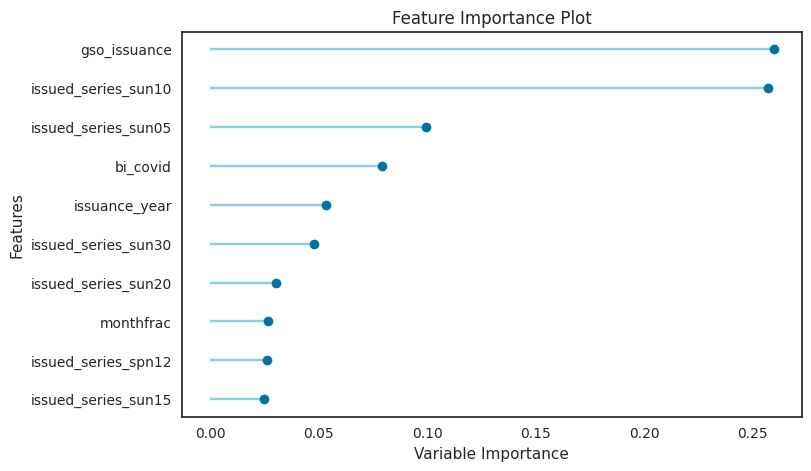

In [ ]:
plot_model(xgb_modified, plot = 'feature')

### Bagging -- 66.65%

In [ ]:
# ensemble with bagging
xgb_bagged = ensemble_model(xgb_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2442605.7500,13006228422656.0000,3606415.0000,0.6825,2.1100,0.6030
1,2594514.7500,12447514624000.0000,3528103.5000,0.6468,1.0808,0.5670
2,2305118.0000,9867590893568.0000,3141272.2500,0.6933,0.6393,0.7712
3,2215063.5000,11129512263680.0000,3336092.2500,0.6056,1.3648,1.1448
4,2333852.2500,12983215325184.0000,3603223.0000,0.6954,1.1671,0.6156
5,2519017.0000,15806003937280.0000,3975676.5000,0.6148,0.7072,1.0111
6,2163875.7500,9500385869824.0000,3082269.5000,0.7156,0.6360,0.7911
7,1979422.1250,7710491803648.0000,2776777.2500,0.6988,1.3103,0.8209
8,2895177.5000,20030540480512.0000,4475549.0000,0.5692,1.6392,0.7357


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 67.18%

In [ ]:
# ensemble with boosting
xgb_boosted = ensemble_model(xgb_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2471540.2500,12656082681856.0000,3557538.7500,0.6910,2.1375,0.5831
1,2620279.2500,12965241683968.0000,3600728.0000,0.6321,0.8665,0.5991
2,2289364.2500,9340064890880.0000,3056152.0000,0.7097,0.6893,0.7930
3,2163666.0000,10122340335616.0000,3181562.5000,0.6413,1.3826,1.1197
4,2466326.0000,14487617798144.0000,3806260.2500,0.6601,1.1615,0.6924
5,2504709.0000,15349323923456.0000,3917821.2500,0.6259,0.7334,0.9673
6,2141008.5000,8479847743488.0000,2912017.7500,0.7462,0.7952,0.8802
7,2034988.8750,8349933895680.0000,2889625.2500,0.6738,1.3160,0.7699
8,2869634.7500,19368295530496.0000,4400942.5000,0.5835,1.6735,0.7295


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

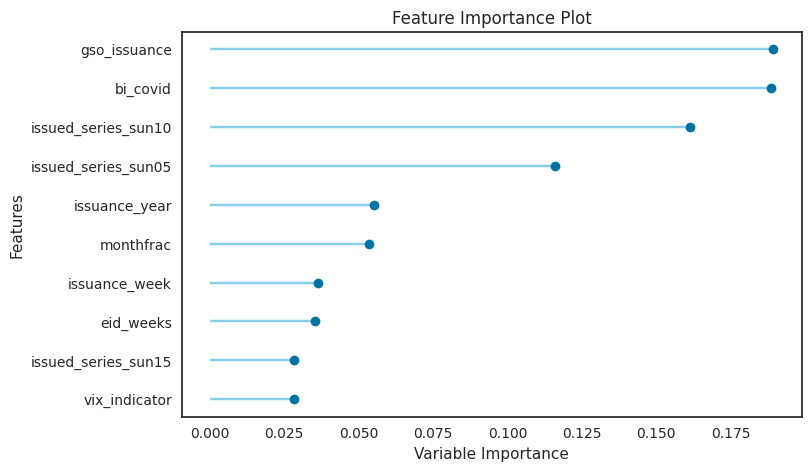

In [ ]:
plot_model(xgb_boosted, plot = 'feature')

## Extra Trees Regressor

### Raw -- 65.80%

In [ ]:
# train a et model with default params
et_raw = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2448865.3690,12067590213900.4883,3473843.7233,0.7054,1.8563,0.5821
1,2627708.3363,14414666981403.6191,3796665.2448,0.5910,1.2117,0.5441
2,2379983.5238,11848464026728.6074,3442159.7910,0.6317,0.6098,0.6781
3,2126584.5655,11236970771724.9590,3352159.1209,0.6018,1.0455,1.1630
4,2511380.9494,13307493075483.0977,3647943.6777,0.6878,0.9234,0.5972
5,2455619.3653,16116917632879.9863,4014588.1025,0.6072,0.7518,0.9176
6,2150492.7515,9178317494182.0137,3029573.8140,0.7253,0.5451,0.5905
7,1984060.6108,8182407571526.8867,2860490.7921,0.6803,1.2792,0.6617
8,2742279.9581,17489019996295.0586,4181987.5653,0.6239,1.5711,0.6371


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 55.65%

In [ ]:
# tune hyperparameters of et
et_tuned = tune_model(et_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2892045.1092,17477936933664.5352,4180662.2602,0.5733,2.3910,0.9121
1,2770365.0688,15284449985318.9961,3909533.2183,0.5663,1.2987,0.6423
2,2668128.0997,12154856156052.6172,3486381.5276,0.6222,0.7187,0.9471
3,2716764.0895,16008640564257.4883,4001079.9248,0.4327,1.4156,2.2228
4,2765361.4633,17838582425225.9883,4223574.6028,0.5815,1.3212,0.8317
5,3047040.0186,22129742610112.3281,4704226.0373,0.4607,0.8366,1.3053
6,2560430.0933,13100669459400.2148,3619484.6953,0.6079,0.7314,1.0569
7,2342270.7125,9514706923633.6914,3084591.8569,0.6283,1.4547,1.2340
8,3353053.2552,25825890676301.5703,5081918.0116,0.4446,1.8059,1.0446


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 61.01%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
et_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 4, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
et_modified = tune_model(et_raw, custom_grid=et_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2711054.2679,16091666248558.9160,4011441.9164,0.6072,2.2658,1.0392
1,2535228.2820,13317622006253.5488,3649331.7205,0.6221,1.2559,0.5672
2,2383103.4457,10187088662879.3594,3191721.8962,0.6834,0.6659,0.8333
3,2486167.0238,13744570445677.8281,3707367.0503,0.5129,1.3416,2.2120
4,2733949.4189,17225420584304.1191,4150351.8627,0.5959,1.2693,0.7781
5,2765643.4832,19509018163818.9023,4416901.4211,0.5246,0.7599,1.0945
6,2291368.5146,10585507653451.6855,3253537.7135,0.6831,0.6636,0.9103
7,2203186.6696,8588063405357.6943,2930539.7805,0.6645,1.3573,1.0357
8,3103324.6409,22897546374932.0195,4785138.0727,0.5076,1.7563,0.8917


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 65.50%

In [ ]:
# ensemble with bagging
et_bagged = ensemble_model(et_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2481680.3143,12436451010576.8477,3526535.2700,0.6964,2.1241,0.6544
1,2623362.9930,13268847981453.0742,3642642.9940,0.6235,1.2096,0.5539
2,2344484.5453,10264783746296.5762,3203870.1201,0.6809,0.6207,0.7372
3,2282095.6375,12719440593325.8789,3566432.4742,0.5493,1.1849,1.5274
4,2423207.0095,13321551144856.7402,3649870.0175,0.6875,1.1247,0.6494
5,2486645.1669,16614688254102.8320,4076111.9040,0.5951,0.6940,0.9490
6,2150263.1696,9309920148470.5801,3051216.1753,0.7213,0.5697,0.6590
7,1990013.1413,8000876927645.4463,2828582.1409,0.6874,1.3044,0.8098
8,2880543.0311,19677027699895.4023,4435879.5858,0.5769,1.6277,0.7458


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 66.88%

In [ ]:
# ensemble with boosting
et_boosted = ensemble_model(et_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2488682.8091,12780061985829.8457,3574921.2559,0.6880,2.1687,0.6511
1,2648432.0024,14410508842159.1309,3796117.6012,0.5911,1.2299,0.5613
2,2265929.3810,10566916223562.4883,3250679.3480,0.6715,0.6081,0.6788
3,2079082.2012,9839102104855.8965,3136734.3057,0.6513,1.2127,1.7972
4,2438010.8632,12718567603143.2559,3566310.0823,0.7016,1.0527,0.6647
5,2500121.2954,16521539780896.3770,4064669.7013,0.5974,0.6725,0.9186
6,2103762.8783,8332125492695.2852,2886542.1342,0.7506,0.5801,0.7089
7,1968920.0244,8217778620993.7764,2866666.8137,0.6790,1.2734,0.6917
8,2810362.7126,17657185236838.1484,4202045.3635,0.6203,1.7043,0.7588


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

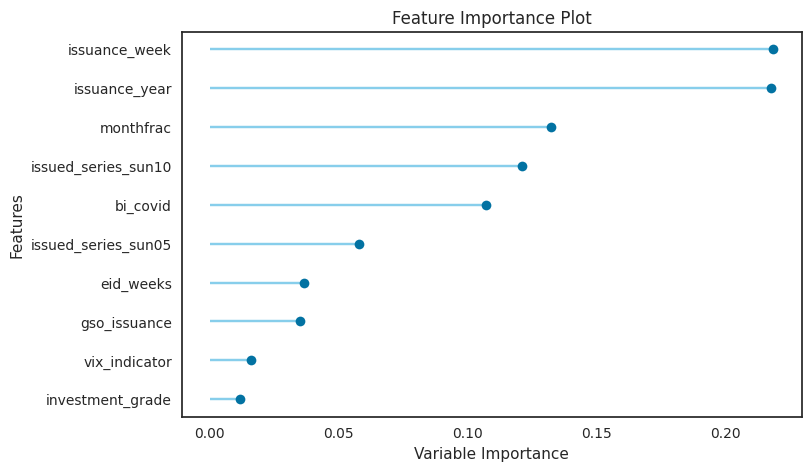

In [ ]:
plot_model(et_boosted, plot = 'feature')

## Random Forest Regressor

### Raw -- 65.46%

In [ ]:
# train a rf model with default params
rf_raw = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2508046.9091,12513584747695.7324,3537454.5577,0.6945,2.2204,0.6930
1,2679400.0829,13392004148135.2383,3659508.7304,0.6200,1.2083,0.5747
2,2388393.8652,10717792684639.9082,3273804.0083,0.6669,0.6378,0.7803
3,2234322.2883,11264582803252.4727,3356275.1382,0.6008,1.3735,1.4847
4,2467753.2986,14836738459056.2012,3851848.7067,0.6519,1.1416,0.6526
5,2472669.4079,15998060291095.1016,3999757.5290,0.6101,0.7230,1.0262
6,2184031.2534,10517583576898.9258,3243082.4191,0.6852,0.5682,0.6346
7,2040079.2750,7722294214287.2578,2778901.6201,0.6983,1.3321,0.8296
8,2915950.2849,19768448344432.4805,4446172.3251,0.5749,1.6397,0.7540


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tuning -- 57.98%

In [ ]:
# tune hyperparameters of rf
rf_tuned = tune_model(rf_raw)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2845574.7506,17101801054350.2617,4135432.3903,0.5825,2.3989,0.8872
1,2769622.4275,14133240851911.3516,3759420.2814,0.5990,1.3037,0.6281
2,2706476.4360,13724044964913.8848,3704597.8142,0.5734,0.7184,0.9303
3,2541676.1784,13179516712806.9023,3630360.4109,0.5330,1.4335,2.2284
4,2740053.8005,18538928849821.3594,4305685.6422,0.5650,1.3213,0.9442
5,2923821.5416,20278077603502.3789,4503118.6531,0.5058,0.8190,1.2226
6,2487484.3428,12890699478457.0996,3590362.0261,0.6141,0.7010,1.0082
7,2295958.0866,8886208132323.3418,2980974.3596,0.6529,1.4385,1.1303
8,3218077.6664,24579530247747.2930,4957774.7274,0.4714,1.8379,1.0532


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Modifying -- 64.20%

In [ ]:
# define a more comprehensive tuning grid for Random Forest Regressor
rf_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 4, 8, 12, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Tune model with the optimized grid and optimize for Mean Squared Error (mse)
rf_modified = tune_model(rf_raw, custom_grid=rf_grid, optimize='mse', early_stopping=True, choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2548848.6772,13364022464192.6719,3655683.5837,0.6737,2.2657,0.7283
1,2677883.9108,13224155448280.8906,3636503.1896,0.6248,1.2304,0.5772
2,2441973.3913,11246330061967.7715,3353554.8396,0.6504,0.6571,0.8091
3,2296727.8902,11680397570306.0410,3417659.6627,0.5861,1.3841,1.6816
4,2541739.9267,15635403492064.3164,3954162.8055,0.6332,1.1821,0.6989
5,2560953.1230,17107110449465.4492,4136074.2800,0.5831,0.7335,1.0346
6,2236698.1488,10909998133779.6387,3303028.6305,0.6734,0.5843,0.6736
7,2060082.3286,7465493940353.2764,2732305.6089,0.7084,1.3587,0.8978
8,3015720.5875,20996952698057.6406,4582243.1950,0.5485,1.6843,0.8421


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Bagging -- 62.84%

In [ ]:
# ensemble with bagging
rf_bagged = ensemble_model(rf_raw, method = 'Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2637624.5212,14179482024521.5352,3765565.2995,0.6538,2.2992,0.7882
1,2703602.8066,13680185355446.5723,3698673.4589,0.6118,1.2627,0.6060
2,2497718.1548,11659795367740.7266,3414644.2520,0.6376,0.6700,0.8402
3,2430166.6596,12727141200756.0000,3567511.9062,0.5490,1.3900,2.0835
4,2598752.2857,15369992985908.2500,3920458.2622,0.6394,1.2302,0.7528
5,2766213.9567,17905282640420.4180,4231463.4159,0.5636,0.7736,1.1536
6,2302858.4265,11207201347875.6797,3347715.8404,0.6645,0.6335,0.8018
7,2093325.9156,7718802820418.0674,2778273.3524,0.6985,1.3803,0.9781
8,3092586.8730,22331577859405.8281,4725629.8902,0.5198,1.7174,0.9003


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

### Boosting -- 65.45%

In [ ]:
# ensemble with boosting
rf_boosted = ensemble_model(rf_raw, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2531286.5515,12271120705088.1699,3503015.9442,0.7004,2.2489,0.8476
1,2583139.4608,12778488568341.4316,3574701.1859,0.6374,1.2249,0.5877
2,2460249.2287,11263274875282.8633,3356080.2844,0.6499,0.6622,0.8267
3,2293562.8457,11197643173864.2598,3346287.9694,0.6032,1.3666,1.7354
4,2454519.4501,13462226899155.8594,3669090.7456,0.6842,1.2219,0.7148
5,2534667.5683,15780191513275.3340,3972428.9186,0.6154,0.7539,1.0859
6,2301533.3912,10621713687065.0215,3259097.0662,0.6821,0.6451,0.8539
7,2169770.8604,8827567738810.4512,2971122.3029,0.6551,1.3347,0.8852
8,2917425.2934,18209371171531.4141,4267243.9784,0.6084,1.7280,0.8026


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

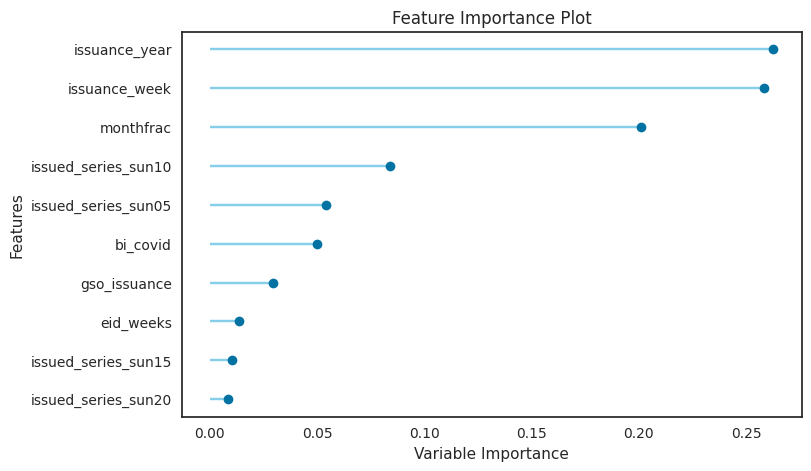

In [ ]:
plot_model(rf_boosted, plot = 'feature')

# Choosen

## Blended -- 70.47%

In [ ]:
# Blend the Boosted Ensembles
blended = blend_models(estimator_list=[lightgbm_modified, xgb_tuned, et_boosted, rf_raw], fold=10)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2338824.3362,11413579695573.5215,3378398.9841,0.7214,2.0720,0.5871
1,2493244.0700,11913308262896.7969,3451566.0595,0.6620,1.1187,0.5200
2,2197401.7369,9053479233690.5840,3008900.0039,0.7186,0.5958,0.6835
3,1998543.6891,8576576187281.9551,2928579.2097,0.6961,1.3418,1.1599
4,2283164.8549,12400125059738.8789,3521381.1296,0.7091,1.1513,0.5659
5,2291654.2538,13567346859858.4258,3683387.9595,0.6694,0.7145,0.9008
6,2142129.0251,8675621416442.5117,2945440.7847,0.7403,0.6081,0.7294
7,1893565.0664,6796267816641.8418,2606965.2504,0.7345,1.2977,0.7246
8,2770901.6741,17345838367652.3359,4164833.5342,0.6270,1.6674,0.6776


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(blended);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2170373.6457,10650446316364.8926,3263502.1551,0.6427,0.5641,0.5867


In [ ]:
# plot_model(blended, plot = 'residuals')

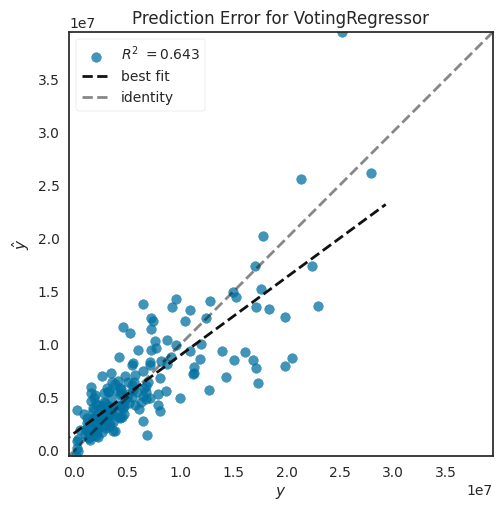

In [ ]:
plot_model(blended, plot = 'error')

## Stacked -- 70.79%

In [ ]:
stacked = stack_models(estimator_list=[lightgbm_modified, xgb_tuned, et_boosted, rf_raw])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2322539.2458,11853398378293.8398,3442876.4686,0.7106,1.9591,0.6262
1,2442471.1920,11781398834300.7598,3432404.2353,0.6657,0.9760,0.5063
2,2189604.3847,8856579452039.5488,2976000.5800,0.7247,0.6321,0.6849
3,1935480.5358,8068827738636.2900,2840568.2070,0.7141,1.3105,1.1115
4,2289637.4005,12128453234841.2402,3482592.8896,0.7154,1.1798,0.5840
5,2305847.4958,13623977587261.3047,3691067.2694,0.6680,0.7052,0.8890
6,2158592.5853,8659816852701.3428,2942756.6758,0.7408,0.6528,0.7955
7,1874150.1782,6675036781941.2832,2583609.2549,0.7392,1.2918,0.7027
8,2755558.9187,17106210343990.0508,4135965.4670,0.6321,1.6863,0.6652


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
predict_model(stacked);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,2186408.6565,10897423453757.5488,3301124.5741,0.6344,0.5694,0.5713


In [ ]:
# plot_model(stacked, plot = 'residuals')

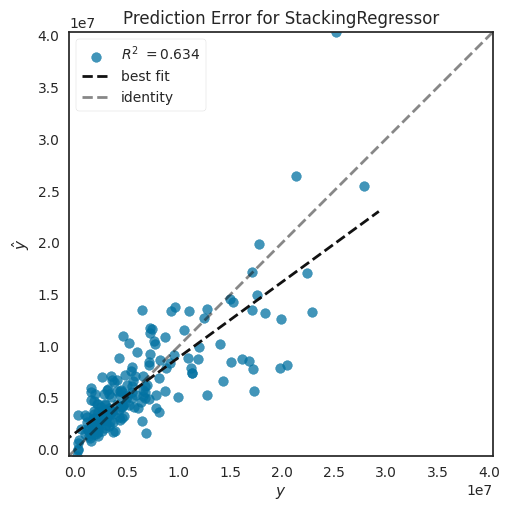

In [ ]:
plot_model(stacked, plot = 'error')

## Finalizing -- 97.66%

In [ ]:
final = finalize_model(stacked)
predict_model(final);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,638622.9991,698241782197.4788,835608.6298,0.9766,0.5028,0.1801


In [ ]:
save_model(final, '/content/drive/MyDrive/00database/20240528_stacked01')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['issuance_year', 'issuance_week',
                                              'monthfrac', 'eid_weeks',
                                              'srbi_issuance', 'vix_indicator',
                                              'bi_covid', 'gso_issuance',
                                              'investment_grade'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['issued_series'],
                                     transformer=SimpleImpute...
                                                              multi_strategy=None,
                                                              n_estimators=290,
                                                              n_jobs=-1,
                                                              num_parallel

# Lelang 28 Mei 2024

## Load

In [ ]:
lelang20240528 = pd.read_excel('/content/drive/MyDrive/00database/db_monthfrac.xlsx', sheet_name='lelang20240528')
lelang20240528['issuance_date'] = pd.to_datetime(lelang20240528['issuance_date'], format='%Y-%m-%d')
lelang20240528.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   issued_series     8 non-null      object        
 1   issuance_date     8 non-null      datetime64[ns]
 2   issuance_year     8 non-null      int64         
 3   issuance_week     8 non-null      int64         
 4   monthfrac         8 non-null      int64         
 5   eid_weeks         8 non-null      int64         
 6   srbi_issuance     8 non-null      int64         
 7   vix_indicator     8 non-null      int64         
 8   bi_covid          8 non-null      int64         
 9   gso_issuance      8 non-null      int64         
 10  investment_grade  8 non-null      int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 832.0+ bytes


## Predict

In [ ]:
# load model
stacked01_20240528 = load_model("/content/drive/MyDrive/00database/20240528_stacked01")

# predict model on new_data
predict03= predict_model(stacked01_20240528, data = lelang20240528)
predict03

# predict model on new_data
# predict03= predict_model(final, data = lelang20240130)
# predict03

Transformation Pipeline and Model Successfully Loaded


,issued_series,issuance_date,issuance_year,issuance_week,monthfrac,eid_weeks,srbi_issuance,vix_indicator,bi_covid,gso_issuance,investment_grade,prediction_label
0,spn03,2024-05-28,2024,22,3,0,0,0,0,0,1,9.294165e+05
1,spn12,2024-05-28,2024,22,12,0,0,0,0,0,1,2.664628e+06
2,sun05,2024-05-28,2024,22,58,0,0,0,0,0,1,8.894799e+06
3,sun08,2024-05-28,2024,22,76,0,0,0,0,0,1,6.426614e+06
4,sun10,2024-05-28,2024,22,116,0,0,0,0,0,1,1.401734e+07
5,sun15,2024-05-28,2024,22,168,0,0,0,0,0,1,7.007648e+06
6,sun20,2024-05-28,2024,22,228,0,0,0,0,0,1,6.420685e+06
7,sun30,2024-05-28,2024,22,361,0,0,0,0,0,1,2.982273e+06


In [ ]:
# @title Lelang 20240528: Per series

# !pip install --upgrade pip
# !pip install tabulate

import tabulate

# Incoming bid per series
predict04 = predict03[['issued_series', 'issuance_date', 'prediction_label']]

# Create a new column with formatted dates
predict04['issuance_date'] = predict04['issuance_date'].dt.strftime('%Y-%m-%d')

# Format the 'prediction_label' column
predict04['prediction_label'] = predict04['prediction_label'].apply(lambda x: '{:,.2f} trillion'.format(x / 1_000_000))

# Convert the DataFrame to a list of dictionaries for tabulate
table_data = predict04.to_dict(orient='records')

# Specify the column alignments
column_alignments = {'issued_series': 'left', 'issuance_date': 'center', 'prediction_label': 'right'}

# Display the formatted DataFrame using tabulate
formatted_table = tabulate.tabulate(table_data, headers="keys", floatfmt=".2f", showindex=False, colalign=list(column_alignments.values()), tablefmt="pipe")

print(formatted_table)

| issued_series   |  issuance_date  |   prediction_label |
|:----------------|:---------------:|-------------------:|
| spn03           |   2024-05-28    |      0.93 trillion |
| spn12           |   2024-05-28    |      2.66 trillion |
| sun05           |   2024-05-28    |      8.89 trillion |
| sun08           |   2024-05-28    |      6.43 trillion |
| sun10           |   2024-05-28    |     14.02 trillion |
| sun15           |   2024-05-28    |      7.01 trillion |
| sun20           |   2024-05-28    |      6.42 trillion |
| sun30           |   2024-05-28    |      2.98 trillion |


In [ ]:
# @title Lelang 20240528: Total

# Sum total incoming bid
incoming_bid = predict03['prediction_label'].sum()

# Round to two decimal places
rounded_bid = round(incoming_bid, 2)
formatted_rounded_bid = 'Rp{:,.2f} million'.format(rounded_bid)

# Adjust to the nearest thousand
formatted_incoming_bid = 'Rp{:,.2f} trillion'.format(rounded_bid / 1000000)

output_message = f"""
According to a stacked machine learning algorithm model with an R-squared value of 70.79%,
the estimated incoming bid for the next issuance is approximately {formatted_rounded_bid}
or {formatted_incoming_bid}.
"""

print(output_message)



According to a stacked machine learning algorithm model with an R-squared value of 70.79%,
the estimated incoming bid for the next issuance is approximately Rp49,343,401.60 million
or Rp49.34 trillion.

